In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization, Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import os

# Path where you've stored the CSV files
data_path = '/content/drive/MyDrive/AIFinance'  # Change this to your actual path

tickers = ['Amazon', 'Apple', 'Facebook', 'Google', 'Netflix']
dfs = []

for ticker in tickers:
    try:
        filepath = os.path.join(data_path, f'{ticker}.csv')
        df = pd.read_csv(filepath)
        df['Ticker'] = ticker
        dfs.append(df)
    except FileNotFoundError:
        print(f"File not found: {filepath}. Skipping {ticker}.")

if dfs:
    combined_df = pd.concat(dfs)
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])
    combined_df.sort_values(['Ticker', 'Date'], inplace=True)
else:
    print("No data files were found. Please check your file paths.")

In [3]:
# Calculate technical indicators
def add_technical_indicators(df):
    # Daily returns
    df['Daily_Return'] = df['Close'].pct_change()

    # Moving Averages
    df['MA_7'] = df['Close'].rolling(window=7).mean()
    df['MA_21'] = df['Close'].rolling(window=21).mean()

    # Volatility
    df['Volatility'] = df['Daily_Return'].rolling(window=21).std()

    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    return df

# Apply to each stock
combined_df = combined_df.groupby('Ticker').apply(add_technical_indicators)
combined_df.dropna(inplace=True)

<ipython-input-3-2314282056>:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Daily_Return'] = df['Close'].pct_change()
<ipython-input-3-2314282056>:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby('Ticker').apply(add_technical_indicators)


In [4]:
# Normalize features per stock
scaler_dict = {}

for ticker in tickers:
    scaler = MinMaxScaler(feature_range=(0, 1))
    ticker_data = combined_df[combined_df['Ticker'] == ticker]
    scaled_data = scaler.fit_transform(ticker_data[['Close', 'Volume', 'MA_7', 'MA_21', 'Volatility', 'RSI']])
    combined_df.loc[combined_df['Ticker'] == ticker, ['Close', 'Volume', 'MA_7', 'MA_21', 'Volatility', 'RSI']] = scaled_data
    scaler_dict[ticker] = scaler

In [5]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length, 0])  # 0 is the 'Close' price position
    return np.array(X), np.array(y)

sequence_length = 30  # Using 30 days of history
X_all, y_all = {}, {}

for ticker in tickers:
    ticker_data = combined_df[combined_df['Ticker'] == ticker][['Close', 'Volume', 'MA_7', 'MA_21', 'Volatility', 'RSI']].values
    X, y = create_sequences(ticker_data, sequence_length)
    X_all[ticker], y_all[ticker] = X, y

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Example for one stock
ticker = 'Amazon'
X, y = X_all[ticker], y_all[ticker]

# Split data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.fit(X_train, y_train,
          batch_size=32,
          epochs=50,
          validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 8.7406e-05 - val_loss: 0.0034
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 6.0801e-05 - val_loss: 0.0026
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 4.9327e-05 - val_loss: 0.0050
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 4.0605e-05 - val_loss: 0.0035
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 3.6338e-05 - val_loss: 0.0110
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3.6282e-05 - val_loss: 0.0059
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3.0878e-05 - val_loss: 0.0038
Epoch 9/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 3.2901e-05 - val_loss: 0.0076
Epoch 10/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 2.9776e-05 - val_loss: 0.0037
Epoch 11/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 2.8590e-05 - val_loss: 0.0046
E

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


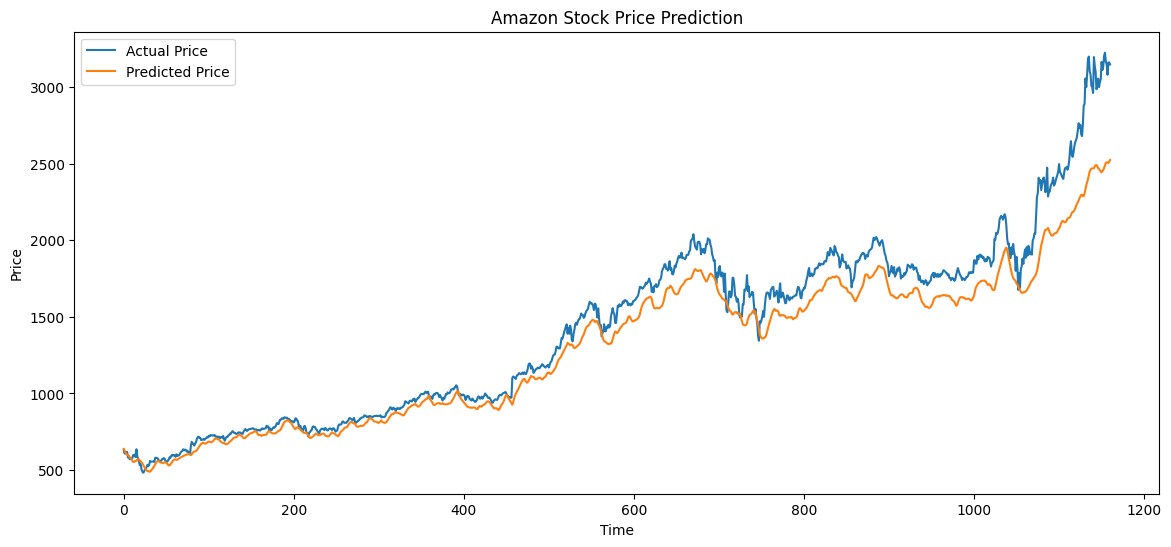

In [7]:
import matplotlib.pyplot as plt

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the scaling
predictions = scaler_dict[ticker].inverse_transform(
    np.concatenate((predictions, np.zeros((len(predictions), 5))), axis=1)
)[:, 0]

actual = scaler_dict[ticker].inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 5))), axis=1)
)[:, 0]

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [8]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Train additional models
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Get predictions from all models
lstm_pred = model.predict(X_test).flatten()
rf_pred = rf.predict(X_test.reshape(X_test.shape[0], -1))
xgb_pred = xgb.predict(X_test.reshape(X_test.shape[0], -1))

# Simple average ensemble
ensemble_pred = (lstm_pred + rf_pred + xgb_pred) / 3

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization

def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=4):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(x)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=0.1
    )(x, x)
    x = tf.keras.layers.Dropout(0.1)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1)(x)
    x = x + res

    # Final output
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    outputs = tf.keras.layers.Dense(1)(x)

    return tf.keras.Model(inputs, outputs)

# Build and compile the model
transformer_model = build_transformer_model((X_train.shape[1], X_train.shape[2]))
transformer_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = transformer_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0465 - val_loss: 0.0279
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0058 - val_loss: 0.0215
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0027 - val_loss: 0.0174
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0017 - val_loss: 0.0130
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0013 - val_loss: 0.0123
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0011 - val_loss: 0.0154
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 9.5091e-04 - val_loss: 0.0228
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 9.3761e-04 - val_loss: 0.0209
Epoch 9/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 8.2861e-04 - val_loss: 0.0222
Epoch 10/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 7.4340e-04 - val_loss: 0.0245
Epoch 11/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 6.9264e-04 - val_loss: 0.0278
Epoch 12/50
145/145 ━

In [12]:
def backtest(predictions, actual_prices, initial_capital=10000, transaction_cost=0.001):
    capital = initial_capital
    position = 0
    returns = []

    for i in range(1, len(predictions)):
        predicted_return = (predictions[i] - actual_prices[i-1]) / actual_prices[i-1]

        if predicted_return > 0.02:  # 2% expected return threshold
            if position <= 0:
                # Buy
                capital -= capital * transaction_cost
                position = capital / actual_prices[i]
                capital = 0
        elif predicted_return < -0.01:  # 1% stop-loss threshold
            if position > 0:
                # Sell
                capital = position * actual_prices[i]
                capital -= capital * transaction_cost
                position = 0

        current_value = capital + (position * actual_prices[i] if position > 0 else 0)
        returns.append(current_value)

    return returns

In [13]:
from scipy.optimize import minimize

def optimize_portfolio(expected_returns, cov_matrix, risk_aversion=0.5):
    n_assets = len(expected_returns)

    def objective(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return - (portfolio_return - risk_aversion * portfolio_risk)

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(n_assets))
    initial_guess = np.array([1/n_assets] * n_assets)

    result = minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [14]:
def calculate_var(predictions, actuals, confidence_level=0.95):
    errors = actuals - predictions
    return np.percentile(errors, 100 * (1 - confidence_level))

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_dashboard(actual, predicted, ticker):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

    fig.add_trace(go.Scatter(y=actual, name='Actual', line=dict(color='blue')), row=1, col=1)
    fig.add_trace(go.Scatter(y=predicted, name='Predicted', line=dict(color='red')), row=1, col=1)

    errors = actual - predicted
    fig.add_trace(go.Scatter(y=errors, name='Prediction Error', line=dict(color='green')), row=2, col=1)

    fig.update_layout(title=f'{ticker} Stock Prediction Dashboard', hovermode='x unified')
    fig.show()

In [18]:
model_save_path = '/content/drive/MyDrive/AIFinance/faang_transformer.h5'
transformer_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/AIFinance/faang_transformer.h5


In [23]:
!ls '/content/drive/MyDrive/AIFinance'

Amazon.csv  faang_transformer.h5  Google.csv
Apple.csv   Facebook.csv	  Netflix.csv


In [24]:
def predict_stock(ticker, new_data):
    """Preprocess and predict on new data"""
    # Scale the new data using the saved scaler
    scaler = scaler_dict[ticker]
    new_data_scaled = scaler.transform(new_data)

    # Reshape for model (assuming sequence_length=30)
    new_data_reshaped = new_data_scaled.reshape(1, 30, -1)

    # Predict
    prediction = loaded_model.predict(new_data_reshaped)

    # Inverse transform
    dummy_data = np.zeros((1, new_data.shape[1]))
    dummy_data[0,0] = prediction  # Assuming 'Close' price is first column
    return scaler.inverse_transform(dummy_data)[0,0]

# Example usage:
# amazon_new_data = [...]  # Your fresh 30-day window of data
# print(predict_stock('Amazon', amazon_new_data))

In [30]:
!pip install fastapi nest-asyncio pyngrok uvicorn

from fastapi import FastAPI
import nest_asyncio
from pyngrok import ngrok
import uvicorn
import numpy as np

# 1. Configure ngrok - REPLACE THIS WITH YOUR ACTUAL TOKEN
NGROK_AUTH_TOKEN = "2yVxMJdZk5UcMDXITnhbQHAjHcG_6r4HTUT5qG6vPhZjtjNNu"  # Must be in quotes!
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# 2. Create FastAPI app
app = FastAPI()

@app.get("/")
def home():
    return {"message": "FAANG Stock Predictor API"}

@app.post("/predict/{ticker}")
async def predict(ticker: str, data: list):
    """Make predictions for given ticker"""
    try:
        # Check if ticker exists
        if ticker not in scaler_dict:
            return {"error": f"Unsupported ticker. Available: {list(scaler_dict.keys())}"}

        # Convert to numpy and validate shape
        data_array = np.array(data)
        if data_array.shape != (30, 6):  # 30 days, 6 features
            return {"error": f"Need (30, 6) array. Got {data_array.shape}"}

        # Scale and predict
        scaler = scaler_dict[ticker]
        data_scaled = scaler.transform(data_array)
        prediction = loaded_model.predict(data_scaled.reshape(1, 30, 6))

        # Inverse transform
        dummy = np.zeros((1, 6))
        dummy[0,0] = prediction[0,0]  # First column is Close price
        predicted_close = scaler.inverse_transform(dummy)[0,0]

        return {
            "ticker": ticker,
            "predicted_close": float(predicted_close),
            "status": "success"
        }

    except Exception as e:
        return {"error": str(e), "status": "failed"}

# 3. Start the server
if __name__ == "__main__":
    try:
        # Start ngrok tunnel
        ngrok_tunnel = ngrok.connect(8000)
        print('Public URL:', ngrok_tunnel.public_url)

        # Allow nested async calls
        nest_asyncio.apply()

        # Start FastAPI
        uvicorn.run(
            app,
            port=8000,
            host='0.0.0.0'
        )
    except Exception as e:
        print(f"Error: {e}")
        print("Starting without ngrok (local only)")
        uvicorn.run(app, port=8000, host='0.0.0.0')

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-1' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:68> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/main.py", line 580, in run
    server.run()
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
    se

Public URL: https://3e3e-34-48-171-148.ngrok-free.app


INFO:     Started server process [2290]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     108.45.39.165:0 - "GET / HTTP/1.1" 200 OK
INFO:     108.45.39.165:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [2290]


In [32]:
from fastapi.responses import JSONResponse
from fastapi.encoders import jsonable_encoder

@app.post("/predict/{ticker}")
async def predict(ticker: str, data: list):
    try:
        # Input validation
        if ticker not in scaler_dict:
            return JSONResponse(
                status_code=400,
                content=jsonable_encoder({
                    "error": f"Unsupported ticker. Available: {list(scaler_dict.keys())}",
                    "status": "failed"
                })
            )

        # Convert and validate input
        try:
            data_array = np.array(data)
            if data_array.shape != (30, 6):
                raise ValueError("Invalid shape")
        except Exception as e:
            return JSONResponse(
                status_code=400,
                content=jsonable_encoder({
                    "error": f"Invalid data format: {str(e)}. Expected 30 days × 6 features",
                    "status": "failed"
                })
            )

        # Process prediction
        scaler = scaler_dict[ticker]
        data_scaled = scaler.transform(data_array)
        prediction = loaded_model.predict(data_scaled.reshape(1, 30, 6))

        # Inverse transform
        dummy = np.zeros((1, 6))
        dummy[0,0] = prediction[0,0]
        predicted_close = scaler.inverse_transform(dummy)[0,0]

        return JSONResponse(
            status_code=200,
            content=jsonable_encoder({
                "ticker": ticker,
                "predicted_close": float(predicted_close),
                "status": "success"
            })
        )

    except Exception as e:
        return JSONResponse(
            status_code=500,
            content=jsonable_encoder({
                "error": str(e),
                "status": "failed"
            })
        )